In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from transformers import AutoTokenizer,AutoModel
from sklearn.metrics  import accuracy_score,f1_score,precision_score,recall_score
from typing import Dict,List,Optional
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [ ]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
df.shape,test.shape


((6827, 8), (1707, 2))

In [ ]:
import re
import html
def preprocessing(text):
  text = html.unescape(text)
  text = text.lower()

  text = re.sub(r'["“”\'\`~\-=&;#\\/<>\|\[\]\(\)_¶]', ' ', text)  # symbols
  text = re.sub(r'\.{2,}', ' ', text)  # multiple dots
  return text

In [ ]:
test

,id,text
0,0,she wanted to fight over every single little t...
1,1,"anyway, back to tuesday."
2,2,she shrieked at the dog to go back.
3,3,yelling for everyone to get back or get inside...
4,4,still kind of freaky.
...,...,...
1702,1702,"back to earth as i opened my eye, i was lying ..."
1703,1703,"english class, grade 8."
1704,1704,"i went at it twice, until the muscles around m..."
1705,1705,my heart.


In [ ]:
from sklearn.model_selection import  train_test_split
train_size=int(0.8*df.shape[0])
train_df=df.iloc[:train_size,1:7]
val_df=df.iloc[train_size:,1:7]

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Training samples: 5461
Validation samples: 1366


In [ ]:
model_name='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class EmotionDataset(Dataset):
  def __init__(self,dataframe:pd.DataFrame,tokenizer:AutoTokenizer,max_length:int=128):
    self.texts=dataframe['text'].values
    self.labels=dataframe[['anger', 'fear', 'joy', 'sadness', 'surprise']].values
    # self.id=dataframe['id'].values
    self.tokenizer=tokenizer
    self.max_length=max_length
  def __len__(self)->int:
    return len(self.texts)
  def __getitem__(self,idx)->Dict[str,torch.Tensor]:
    text=str(self.texts[idx])
    labels=self.labels[idx]
    # ids=self.id[idx]
    text=preprocessing(text)
    encoding=self.tokenizer(text,
                            truncation=True,
                            add_special_tokens=True,
                            padding='max_length',
                            max_length=self.max_length,
                            return_tensors='pt')
    return {
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        # 'id':ids
        'labels':torch.tensor(labels,dtype=torch.float)
    }





In [ ]:
train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"\nSample from dataset:")
sample = train_dataset[0]
for key, value in sample.items():
    print(f"{key}: {value.shape}")

Training dataset size: 5461
Validation dataset size: 1366

Sample from dataset:
input_ids: torch.Size([128])
attention_mask: torch.Size([128])
labels: torch.Size([5])


In [ ]:
@dataclass
class DataCollator:

    def __call__(self, batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        # ids=[item['id'] for item in batch]
        labels = torch.stack([item['labels'] for item in batch])

        return {
            # 'id':ids,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

collator = DataCollator()
print("Data collator initialized successfully")

Data collator initialized successfully


In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collator
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collator
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

print("\nSample batch from DataLoader:")
for batch in train_loader:
    for key, value in batch.items():
        print(f"{key}: {value.shape}")
    break

Number of training batches: 171
Number of validation batches: 43

Sample batch from DataLoader:
input_ids: torch.Size([32, 128])
attention_mask: torch.Size([32, 128])
labels: torch.Size([32, 5])


##PEFT

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import LoraConfig, TaskType, get_peft_model
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# ---------------------------
# MODEL + PEFT SETUP
# ---------------------------
MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use HF built-in model (has .config)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"  # because BCE loss
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# LoRA c
lora_config = LoraConfig(
    r=2,                        # moderate rank for capacity
    lora_alpha=64,                # default scaling
    target_modules=["dense"],  # adjust internal attention + FFN
    lora_dropout=0.0,             # reduce dropout for underfitting
    bias="none",
    task_type=TaskType.SEQ_CLS
)


# Apply PEFT
model = get_peft_model(model, lora_config)
model = model.to(device)

model.print_trainable_parameters()
print("\n✅ Model ready for PEFT training!\n")

print(f"Device: {device}")
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ---------------------------
# Trainer
# ---------------------------
class Trainer:
    def __init__(self, model: torch.nn.Module, train_loader, val_loader,
                 criterion, optimizer, device: torch.device,
                 checkpoint_path="checkpoint.pth", patience=5, threshold=0.5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        # History will hold lists of metric values per epoch
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [],  'val_acc': [],
            'train_f1': [],   'val_f1': [],
            'train_roc': [],  'val_roc': []
        }
        self.checkpoint_path = checkpoint_path
        self.best_model_path = "best_model.pth"
        self.start_epoch = 0
        self.best_val_acc = 0.0
        self.patience = patience
        self.no_improve_epochs = 0
        self.threshold = threshold  # threshold for converting probs -> binary preds

        # Auto-load last checkpoint if available
        if os.path.exists(self.checkpoint_path):
            print(f"🔄 Found checkpoint. Resuming from {self.checkpoint_path} ...")
            self.load_checkpoint()

    def save_checkpoint(self, epoch, is_best=False):
        """Save model, optimizer, and training state"""
        state = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'best_val_acc': self.best_val_acc,
            'no_improve_epochs': self.no_improve_epochs
        }
        torch.save(state, self.checkpoint_path)

        if is_best:
            torch.save(self.model.state_dict(), self.best_model_path)
            print(f"✅ Best model saved (Val Acc: {self.best_val_acc:.4f})")

    def load_checkpoint(self):
        """Load checkpoint if available"""
        checkpoint = torch.load(self.checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint.get('history', self.history)
        self.best_val_acc = checkpoint.get('best_val_acc', 0.0)
        self.no_improve_epochs = checkpoint.get('no_improve_epochs', 0)
        self.start_epoch = checkpoint.get('epoch', 0) + 1
        print(f"✅ Resumed from epoch {self.start_epoch}")

    def _compute_metrics_from_preds(self, y_true, y_probs, threshold=None):
        """
        y_true: np.array shape (N, num_labels)  (binary 0/1)
        y_probs: np.array shape (N, num_labels) (probabilities 0..1)
        returns: acc, f1_macro, roc_micro
        """
        if threshold is None:
            threshold = self.threshold

        y_pred = (y_probs >= threshold).astype(int)

        # Exact-match accuracy (all labels correct per sample)
        try:
            acc = accuracy_score(y_true, y_pred)
        except Exception as e:
            print("Warning computing accuracy:", e)
            acc = float('nan')

        # F1 (macro)
        try:
            f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        except Exception as e:
            print("Warning computing F1:", e)
            f1 = float('nan')

        # ROC-AUC (micro) - requires at least one positive and one negative per class across dataset
        try:
            # roc_auc_score accepts multilabel-indicator shape directly for y_true and y_scores
            roc = roc_auc_score(y_true, y_probs, average='micro')
        except Exception as e:
            # e.g., Raised when a class has only one label in y_true
            print("Warning computing ROC-AUC (set to nan):", e)
            roc = float('nan')

        return acc, f1, roc

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0

        all_probs = []
        all_labels = []

        for batch in tqdm(self.train_loader, desc="Training", leave=False):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device).float()

            self.optimizer.zero_grad()
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits            # (batch_size, num_labels)
            loss = self.criterion(logits, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

            probs = torch.sigmoid(logits).detach().cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.detach().cpu().numpy())

        avg_loss = total_loss / len(self.train_loader)

        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        train_acc, train_f1, train_roc = self._compute_metrics_from_preds(all_labels, all_probs)
        return avg_loss, train_acc, train_f1, train_roc

    def validate_epoch(self):
        self.model.eval()
        total_loss = 0.0

        all_probs = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation", leave=False):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device).float()

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                loss = self.criterion(logits, labels)

                total_loss += loss.item()

                probs = torch.sigmoid(logits).cpu().numpy()
                all_probs.append(probs)
                all_labels.append(labels.cpu().numpy())

        avg_loss = total_loss / len(self.val_loader)

        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        val_acc, val_f1, val_roc = self._compute_metrics_from_preds(all_labels, all_probs)
        return avg_loss, val_acc, val_f1, val_roc

    def train(self, num_epochs: int):
        print("🚀 Starting training...")

        for epoch in range(self.start_epoch, num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss, train_acc, train_f1, train_roc = self.train_epoch()
            val_loss, val_acc, val_f1, val_roc = self.validate_epoch()

            # store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['train_f1'].append(train_f1)
            self.history['val_f1'].append(val_f1)
            self.history['train_roc'].append(train_roc)
            self.history['val_roc'].append(val_roc)

            # print summary for epoch
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
            print(f"Train F1 (macro): {train_f1:.4f} | Val F1 (macro): {val_f1:.4f}")
            print(f"Train ROC (micro): {train_roc if not np.isnan(train_roc) else 'nan'} | Val ROC (micro): {val_roc if not np.isnan(val_roc) else 'nan'}")

            # Check improvement (based on val_acc by default; change if desired)
            is_best = val_acc > self.best_val_acc
            if is_best:
                self.best_val_acc = val_acc
                self.no_improve_epochs = 0
            else:
                self.no_improve_epochs += 1
                print(f"⚠️ No improvement for {self.no_improve_epochs} epoch(s)")

            # Save checkpoint (always) and best model (if improved)
            self.save_checkpoint(epoch, is_best=is_best)

            # Early stopping
            if self.no_improve_epochs >= self.patience:
                print(f"🛑 Early stopping triggered after {self.patience} epochs without improvement.")
                break

        print("\n🎉 Training complete!")

    # ---------------------------
    # Plotting utilities
    # ---------------------------
    def plot_loss(self):
        plt.figure()
        plt.plot(self.history['train_loss'], label='train_loss')
        plt.plot(self.history['val_loss'], label='val_loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss per epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_accuracy(self):
        plt.figure()
        plt.plot(self.history['train_acc'], label='train_acc')
        plt.plot(self.history['val_acc'], label='val_acc')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy per epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_f1(self):
        plt.figure()
        plt.plot(self.history['train_f1'], label='train_f1 (macro)')
        plt.plot(self.history['val_f1'], label='val_f1 (macro)')
        plt.xlabel("Epoch")
        plt.ylabel("F1 (macro)")
        plt.title("F1 (macro) per epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_roc(self):
        plt.figure()
        plt.plot(self.history['train_roc'], label='train_roc (micro)')
        plt.plot(self.history['val_roc'], label='val_roc (micro)')
        plt.xlabel("Epoch")
        plt.ylabel("ROC-AUC (micro)")
        plt.title("ROC-AUC (micro) per epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

# ---------------------------
# Example usage
# ---------------------------

# Criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# You must have `train_loader` and `val_loader` defined already in your code.
NUM_EPOCHS = 10
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)

trainer.train(NUM_EPOCHS)

# After training, you can plot:
trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()
trainer.plot_roc()

# Save history as numpy for later use if desired:
import json
with open("training_history.json", "w") as f:
    # convert numpy floats to native python
    json.dump({k: [float(x) if (not (isinstance(x, list) or isinstance(x, tuple))) else x for x in v] for k, v in trainer.history.items()}, f)
print("History saved to training_history.json")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 115,973 || all params: 109,602,058 || trainable%: 0.1058

✅ Model ready for PEFT training!

Device: cuda

Model architecture:
PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Lin

Train Loss: 0.5978 | Val Loss: 0.5560
Train Acc: 0.1112 | Val Acc: 0.1501
Train F1 (macro): 0.2046 | Val F1 (macro): 0.1454
Train ROC (micro): 0.644957466668511 | Val ROC (micro): 0.7246012800553536
✅ Best model saved (Val Acc: 0.1501)

Epoch 2/10


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Use the model in eval mode
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Stack all batches
all_probs = np.vstack(all_probs)   # shape: (num_samples, num_labels)
all_labels = np.vstack(all_labels) # shape: (num_samples, num_labels)


In [ ]:
from sklearn.metrics import roc_auc_score

# Micro-average ROC
from sklearn.preprocessing import label_binarize

fpr, tpr, thresholds = {}, {}, {}

# One ROC per class
num_labels = all_labels.shape[1]
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_probs[:, i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr["micro"], tpr["micro"])

print("Micro-average ROC AUC:", roc_auc_micro)

plt.figure(figsize=(8, 6))

# Plot per-class ROC
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(num_labels), colors):
    roc_auc = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} ROC (area = {roc_auc:.2f})')

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (area = {roc_auc_micro:.2f})',
         color='deeppink', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-label ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Full finetuning

In [ ]:
class EmotionClassifier(nn.Module):

    def __init__(self, model_name: str, num_labels: int = 5, dropout: float = 0.3):
        super(EmotionClassifier, self).__init__()

        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits
MODEL_NAME = 'bert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionClassifier(MODEL_NAME, num_labels=5)
model = model.to(device)

print(f"Device: {device}")
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Device: cuda

Model architecture:
EmotionClassifier(
  (transformer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [ ]:
import os
class Trainer:
    def __init__(self, model: torch.nn.Module, train_loader, val_loader,
                 criterion, optimizer, device: torch.device,
                 checkpoint_path="checkpoint.pth", patience=5, threshold=0.5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        # History will hold lists of metric values per epoch
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [],  'val_acc': [],
            'train_f1': [],   'val_f1': [],
            'train_roc': [],  'val_roc': []
        }
        self.checkpoint_path = checkpoint_path
        self.best_model_path = "best_model.pth"
        self.start_epoch = 0
        self.best_val_acc = 0.0
        self.patience = patience
        self.no_improve_epochs = 0
        self.threshold = threshold  # threshold for converting probs -> binary preds

        # Auto-load last checkpoint if available
        if os.path.exists(self.checkpoint_path):
            print(f"🔄 Found checkpoint. Resuming from {self.checkpoint_path} ...")
            self.load_checkpoint()

    def save_checkpoint(self, epoch, is_best=False):
        """Save model, optimizer, and training state"""
        state = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history,
            'best_val_acc': self.best_val_acc,
            'no_improve_epochs': self.no_improve_epochs
        }
        torch.save(state, self.checkpoint_path)

        if is_best:
            torch.save(self.model.state_dict(), self.best_model_path)
            print(f"✅ Best model saved (Val Acc: {self.best_val_acc:.4f})")

    def load_checkpoint(self):
        """Load checkpoint if available"""
        checkpoint = torch.load(self.checkpoint_path, map_location=self.device,weights_only=False)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        # self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.history = checkpoint.get('history', self.history)
        self.best_val_acc = checkpoint.get('best_val_acc', 0.0)
        self.no_improve_epochs = checkpoint.get('no_improve_epochs', 0)
        self.start_epoch = checkpoint.get('epoch', 0) + 1
        print(f"✅ Resumed from epoch {self.start_epoch}")

    def _compute_metrics_from_preds(self, y_true, y_probs, threshold=None):
        """
        y_true: np.array shape (N, num_labels)  (binary 0/1)
        y_probs: np.array shape (N, num_labels) (probabilities 0..1)
        returns: acc, f1_macro, roc_micro
        """
        if threshold is None:
            threshold = self.threshold

        y_pred = (y_probs >= threshold).astype(int)

        # Exact-match accuracy (all labels correct per sample)
        try:
            acc = accuracy_score(y_true, y_pred)
        except Exception as e:
            print("Warning computing accuracy:", e)
            acc = float('nan')

        # F1 (macro)
        try:
            f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
        except Exception as e:
            print("Warning computing F1:", e)
            f1 = float('nan')

        # ROC-AUC (micro) - requires at least one positive and one negative per class across dataset
        try:
            # roc_auc_score accepts multilabel-indicator shape directly for y_true and y_scores
            roc = roc_auc_score(y_true, y_probs, average='micro')
        except Exception as e:
            # e.g., Raised when a class has only one label in y_true
            print("Warning computing ROC-AUC (set to nan):", e)
            roc = float('nan')

        return acc, f1, roc

    def train_epoch(self):
        self.model.train()
        total_loss = 0.0

        all_probs = []
        all_labels = []

        for batch in tqdm(self.train_loader, desc="Training", leave=False):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device).float()

            self.optimizer.zero_grad()
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs            # (batch_size, num_labels)
            loss = self.criterion(logits, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

            probs = torch.sigmoid(logits).detach().cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.detach().cpu().numpy())

        avg_loss = total_loss / len(self.train_loader)

        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        train_acc, train_f1, train_roc = self._compute_metrics_from_preds(all_labels, all_probs)
        return avg_loss, train_acc, train_f1, train_roc

    def validate_epoch(self):
        self.model.eval()
        total_loss = 0.0

        all_probs = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validation", leave=False):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device).float()

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs
                loss = self.criterion(logits, labels)

                total_loss += loss.item()

                probs = torch.sigmoid(logits).cpu().numpy()
                all_probs.append(probs)
                all_labels.append(labels.cpu().numpy())

        avg_loss = total_loss / len(self.val_loader)

        all_probs = np.vstack(all_probs)
        all_labels = np.vstack(all_labels)

        val_acc, val_f1, val_roc = self._compute_metrics_from_preds(all_labels, all_probs)
        return avg_loss, val_acc, val_f1, val_roc

    def train(self, num_epochs: int):
        print("🚀 Starting training...")

        for epoch in range(self.start_epoch, num_epochs):
            print(f"\nEpoch {epoch + 1}/{num_epochs}")

            train_loss, train_acc, train_f1, train_roc = self.train_epoch()
            val_loss, val_acc, val_f1, val_roc = self.validate_epoch()

            # store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['train_f1'].append(train_f1)
            self.history['val_f1'].append(val_f1)
            self.history['train_roc'].append(train_roc)
            self.history['val_roc'].append(val_roc)

            # print summary for epoch
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
            print(f"Train F1 (macro): {train_f1:.4f} | Val F1 (macro): {val_f1:.4f}")
            print(f"Train ROC (micro): {train_roc if not np.isnan(train_roc) else 'nan'} | Val ROC (micro): {val_roc if not np.isnan(val_roc) else 'nan'}")

            # Check improvement (based on val_acc by default; change if desired)
            is_best = val_acc > self.best_val_acc
            if is_best:
                self.best_val_acc = val_acc
                self.no_improve_epochs = 0
            else:
                self.no_improve_epochs += 1
                print(f"⚠️ No improvement for {self.no_improve_epochs} epoch(s)")

            # Save checkpoint (always) and best model (if improved)
            self.save_checkpoint(epoch, is_best=is_best)

            # Early stopping
            if self.no_improve_epochs >= self.patience:
                print(f"🛑 Early stopping triggered after {self.patience} epochs without improvement.")
                break

        print("\n🎉 Training complete!")

    # ---------------------------
    # Plotting utilities
    # ---------------------------
    def plot_loss(self):
        plt.figure()
        plt.plot(self.history['train_loss'], label='train_loss')
        plt.plot(self.history['val_loss'], label='val_loss')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss per epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_accuracy(self):
        plt.figure()
        plt.plot(self.history['train_acc'], label='train_acc')
        plt.plot(self.history['val_acc'], label='val_acc')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy per epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_f1(self):
        plt.figure()
        plt.plot(self.history['train_f1'], label='train_f1 (macro)')
        plt.plot(self.history['val_f1'], label='val_f1 (macro)')
        plt.xlabel("Epoch")
        plt.ylabel("F1 (macro)")
        plt.title("F1 (macro) per epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_roc(self):
        plt.figure()
        plt.plot(self.history['train_roc'], label='train_roc (micro)')
        plt.plot(self.history['val_roc'], label='val_roc (micro)')
        plt.xlabel("Epoch")
        plt.ylabel("ROC-AUC (micro)")
        plt.title("ROC-AUC (micro) per epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

# ---------------------------
# Example usage
# ---------------------------

# Criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

# You must have `train_loader` and `val_loader` defined already in your code.
NUM_EPOCHS = 20
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, device)

trainer.train(NUM_EPOCHS)

# After training, you can plot:
trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()
trainer.plot_roc()

# Save history as numpy for later use if desired:
import json
with open("training_history.json", "w") as f:
    # convert numpy floats to native python
    json.dump({k: [float(x) if (not (isinstance(x, list) or isinstance(x, tuple))) else x for x in v] for k, v in trainer.history.items()}, f)
print("History saved to training_history.json")


🔄 Found checkpoint. Resuming from checkpoint.pth ...


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 4.12 MiB is free. Process 8380 has 8.68 GiB memory in use. Process 8377 has 6.05 GiB memory in use. Of the allocated memory 5.52 GiB is allocated by PyTorch, and 418.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
# Load the best model
model.load_state_dict(torch.load('/content/best_model.pth'))
print("Best model loaded successfully")

Best model loaded successfully


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Use the model in eval mode
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Stack all batches
all_probs = np.vstack(all_probs)   # shape: (num_samples, num_labels)
all_labels = np.vstack(all_labels) # shape: (num_samples, num_labels)


In [ ]:
from sklearn.metrics import roc_auc_score

# Micro-average ROC
from sklearn.preprocessing import label_binarize

fpr, tpr, thresholds = {}, {}, {}

# One ROC per class
num_labels = all_labels.shape[1]
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_probs[:, i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels.ravel(), all_probs.ravel())
roc_auc_micro = auc(fpr["micro"], tpr["micro"])

print("Micro-average ROC AUC:", roc_auc_micro)


Micro-average ROC AUC: 0.948835340157287


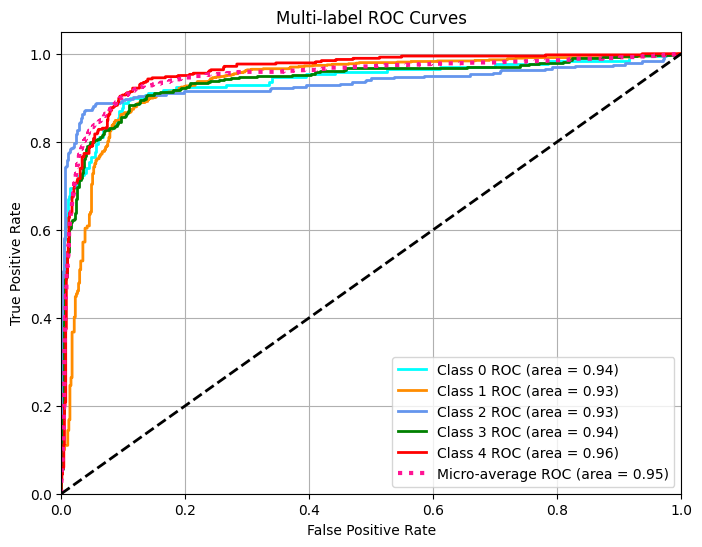

In [ ]:

plt.figure(figsize=(8, 6))

# Plot per-class ROC
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red']
for i, color in zip(range(num_labels), colors):
    roc_auc = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} ROC (area = {roc_auc:.2f})')

# Plot micro-average ROC
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (area = {roc_auc_micro:.2f})',
         color='deeppink', linestyle=':', linewidth=3)

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-label ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
all_labels.shape

(1366, 5)

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np

thresholds = {}
for i in range(all_labels.shape[1]):  # for each label
    fpr, tpr, th = roc_curve(all_labels[:, i], all_probs[:, i])
    j_scores = tpr - fpr
    best_th = th[np.argmax(j_scores)]
    thresholds[f'Class {i}'] = round(best_th, 3)

print(thresholds)


{'Class 0': np.float32(0.027), 'Class 1': np.float32(0.895), 'Class 2': np.float32(0.123), 'Class 3': np.float32(0.153), 'Class 4': np.float32(0.172)}


In [ ]:
import numpy as np

# Your predicted probabilities array (shape: [n_samples, 5])
# all_probs = np.array([...], dtype=np.float32)

# Your class-specific optimal thresholds
# Convert the dict into a NumPy array for easy broadcasting
thr_values = np.array(list(thresholds.values()), dtype=np.float32)

# Apply thresholds per class to get binary predictions
binary_preds = (all_probs >= thr_values).astype(int)

print("Binary Predictions (first 5 rows):\n", binary_preds[:5])
print("\nShape:", binary_preds.shape)


Binary Predictions (first 5 rows):
 [[0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]

Shape: (1366, 5)


In [ ]:
f1_score(all_labels, binary_preds, average='macro', zero_division=0)

0.8225514795938016

## submission

In [ ]:
class EmotionDataset(Dataset):
  def __init__(self,dataframe:pd.DataFrame,tokenizer:AutoTokenizer,max_length:int=128):
    self.texts=dataframe['text'].values
    # self.labels=dataframe[['anger', 'fear', 'joy', 'sadness', 'surprise']].values
    self.id=dataframe['id'].values
    self.tokenizer=tokenizer
    self.max_length=max_length
  def __len__(self)->int:
    return len(self.texts)
  def __getitem__(self,idx)->Dict[str,torch.Tensor]:
    text=str(self.texts[idx])
    # labels=self.labels[idx]
    ids=self.id[idx]
    text=preprocessing(text)
    encoding=self.tokenizer(text,
                            truncation=True,
                            add_special_tokens=True,
                            padding='max_length',
                            max_length=self.max_length,
                            return_tensors='pt')
    return {
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'id':ids
        # 'labels':torch.tensor(labels,dtype=torch.float)
    }




test_dataset = EmotionDataset(test, tokenizer)

@dataclass
class DataCollator:

    def __call__(self, batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        ids=[item['id'] for item in batch]
        # labels = torch.stack([item['labels'] for item in batch])

        return {
            'id':ids,
            'input_ids': input_ids,
            'attention_mask': attention_mask
            # 'labels': labels
        }

collator = DataCollator()
print("Data collator initialized successfully")

Data collator initialized successfully


In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collator
)

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Use the model in eval mode
model.eval()
all_probs = []
all_ids = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        ids = batch['id']

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu().numpy())

        all_ids.append(ids)

# Stack all batches
all_probs = np.vstack(all_probs)   # shape: (num_samples, num_labels)
all_ids


[[np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(4),
  np.int64(5),
  np.int64(6),
  np.int64(7),
  np.int64(8),
  np.int64(9),
  np.int64(10),
  np.int64(11),
  np.int64(12),
  np.int64(13),
  np.int64(14),
  np.int64(15),
  np.int64(16),
  np.int64(17),
  np.int64(18),
  np.int64(19),
  np.int64(20),
  np.int64(21),
  np.int64(22),
  np.int64(23),
  np.int64(24),
  np.int64(25),
  np.int64(26),
  np.int64(27),
  np.int64(28),
  np.int64(29),
  np.int64(30),
  np.int64(31)],
 [np.int64(32),
  np.int64(33),
  np.int64(34),
  np.int64(35),
  np.int64(36),
  np.int64(37),
  np.int64(38),
  np.int64(39),
  np.int64(40),
  np.int64(41),
  np.int64(42),
  np.int64(43),
  np.int64(44),
  np.int64(45),
  np.int64(46),
  np.int64(47),
  np.int64(48),
  np.int64(49),
  np.int64(50),
  np.int64(51),
  np.int64(52),
  np.int64(53),
  np.int64(54),
  np.int64(55),
  np.int64(56),
  np.int64(57),
  np.int64(58),
  np.int64(59),
  np.int64(60),
  np.int64(61),
  np.int64(62),
 

In [ ]:
all_probs

(1707, 5)

In [ ]:
import numpy as np

# Your predicted probabilities array (shape: [n_samples, 5])
# all_probs = np.array([...], dtype=np.float32)

# Your class-specific optimal thresholds
# Convert the dict into a NumPy array for easy broadcasting
thr_values = np.array(list(thresholds.values()), dtype=np.float32)

# Apply thresholds per class to get binary predictions
binary_preds = (all_probs >= thr_values).astype(int)

print("Binary Predictions (first 5 rows):\n", binary_preds[:5])
print("\nShape:", binary_preds.shape)


Binary Predictions (first 5 rows):
 [[1 1 0 1 0]
 [0 0 0 0 0]
 [1 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 1]]

Shape: (1707, 5)


In [ ]:
pred_df=pd.DataFrame(binary_preds,columns=['anger', 'fear', 'joy', 'sadness', 'surprise'])

In [ ]:
np.vstack(all_ids)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 32 and the array at index 53 has size 11

In [ ]:
pred_df['id']=test['id']
pred_df=pred_df[['id','anger', 'fear', 'joy', 'sadness', 'surprise']]

In [ ]:
pred_df

,id,anger,fear,joy,sadness,surprise
0,0,1,1,0,1,0
1,1,0,0,0,0,0
2,2,1,1,0,0,0
3,3,0,1,0,0,0
4,4,0,1,0,0,1
...,...,...,...,...,...,...
1702,1702,0,1,0,0,1
1703,1703,0,0,0,0,0
1704,1704,0,1,0,1,0
1705,1705,0,0,0,0,0


In [ ]:
pred_df.to_csv('fullfinetuning.csv',index=False)